In [ ]:
!pip install torchsummary

In [1]:
# run after you enable GPU and restart runtime
import torch, subprocess, os
print("torch.cuda.is_available():", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))
    !nvidia-smi
else:
    print("No GPU visible. Make sure you enabled GPU in Colab (Runtime → Change runtime type).")


torch.cuda.is_available(): True
Device: Tesla T4
Sat Nov 15 02:05:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("khanfashee/nih-chest-x-ray-14-224x224-resized")

print("Path to dataset files:", path)

100%|██████████| 2.30G/2.30G [01:45<00:00, 23.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3


In [5]:
# ============================================
# 1) Imports
# ============================================
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet121
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [6]:
# ============================================
# 2) Paths
# ============================================
base = "/root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3"
csv_path = f"{base}/Data_Entry_2017.csv"
img_dir = f"{base}/images-224/images-224"

In [7]:
# ============================================
# 3) Load CSV + filter only available images
# ============================================
df = pd.read_csv(csv_path)
available_images = set(os.listdir(img_dir))

df = df[df["Image Index"].isin(available_images)]
df = df.reset_index(drop=True)

print("Total usable images:", len(df))


Total usable images: 112120


In [8]:
# ============================================
# 4) Create train/test split (80/20)
# ============================================
train_files, test_files = train_test_split(
    df["Image Index"].tolist(),
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Train:", len(train_files), " Test:", len(test_files))

Train: 89696  Test: 22424


In [9]:
# ============================================
# 5) Disease classes
# ============================================
CLASSES = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]


In [10]:
# ============================================
# 6) Dataset class
# ============================================
class NIHChestXray(Dataset):
    def __init__(self, csv_df, file_list, img_dir, transform=None):
        self.csv_df = csv_df
        self.file_list = file_list
        self.img_dir = img_dir
        self.transform = transform
        self.index_map = {row["Image Index"]: i for i, row in csv_df.iterrows()}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        row = self.csv_df.iloc[self.index_map[img_name]]

        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        labels = row["Finding Labels"].split("|")
        target = torch.zeros(len(CLASSES))
        for l in labels:
            if l in CLASSES:
                target[CLASSES.index(l)] = 1

        return img, target


In [11]:
# ============================================
# 7) Transforms + DataLoaders
# ============================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_data = NIHChestXray(df, train_files, img_dir, transform)
test_data  = NIHChestXray(df, test_files, img_dir, transform)

train_loader = DataLoader(train_data, batch_size=48, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data,  batch_size=48, shuffle=False, num_workers=2, pin_memory=True)


print("Loaders ready.")

Loaders ready.


In [12]:
# ============================================
# 8) Model
# ============================================
model = densenet121(weights="IMAGENET1K_V1")
model.classifier = nn.Linear(1024, 14)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# AMP
scaler = torch.cuda.amp.GradScaler()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 226MB/s]
/tmp/ipython-input-1248015569.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [13]:
# ============================================
# 9) Training loop with tqdm + AMP
# ============================================
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    pbar = tqdm(loader, desc="Training", leave=False)

    for imgs, labels in pbar:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    return total_loss / len(loader)

In [14]:
# ============================================
# 10) Evaluation (AUC)
# ============================================
def evaluate_auc(model, loader, device, num_classes=14):
    model.eval()
    preds_list = []
    labels_list = []

    pbar = tqdm(loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for imgs, labels in pbar:
            imgs = imgs.to(device, non_blocking=True)

            with torch.amp.autocast('cuda'):
                logits = model(imgs)

            preds = torch.sigmoid(logits).cpu().numpy()

            preds_list.append(preds)
            labels_list.append(labels.numpy())

    y_pred = np.vstack(preds_list)
    y_true = np.vstack(labels_list)

    aucs = []
    for i in range(num_classes):
        try:
            aucs.append(roc_auc_score(y_true[:, i], y_pred[:, i]))
        except:
            aucs.append(np.nan)

    return np.nanmean(aucs), aucs

In [15]:
# ============================================
# 11) Train
# ============================================
epochs = 5

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    avg_auc, _ = evaluate_auc(model, test_loader, device)
    print(f"Loss: {loss:.4f} | Avg AUC: {avg_auc:.4f}")

# ============================================
# 12) Save model
# ============================================
torch.save(model.state_dict(), "chexnet_224.pth")
print("Model saved.")


Epoch 1/5


Loss: 0.1609 | Avg AUC: 0.8220

Epoch 2/5


Loss: 0.1441 | Avg AUC: 0.8323

Epoch 3/5


Loss: 0.1370 | Avg AUC: 0.8336

Epoch 4/5


Loss: 0.1286 | Avg AUC: 0.8352

Epoch 5/5


Loss: 0.1164 | Avg AUC: 0.8275
Model saved.


In [16]:
import torch

def compute_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            correct += (preds == labels).sum().item()
            total += labels.numel()

    acc = (correct / total) * 100
    return acc
acc = compute_accuracy(model, test_loader, device)
print(f"Accuracy: {acc:.2f}%")


Accuracy: 94.90%


In [21]:
def evaluate_auc(model, loader, device, num_classes=14):
    model.eval()
    preds_list = []
    labels_list = []

    pbar = tqdm(loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for imgs, labels in pbar:
            imgs = imgs.to(device, non_blocking=True)

            with torch.amp.autocast('cuda'):
                logits = model(imgs)

            preds = torch.sigmoid(logits).cpu().numpy()

            preds_list.append(preds)
            labels_list.append(labels.numpy())

    y_pred = np.vstack(preds_list)
    y_true = np.vstack(labels_list)

    aucs = []
    for i in range(num_classes):
        try:
            aucs.append(roc_auc_score(y_true[:, i], y_pred[:, i]))
        except:
            aucs.append(np.nan)

    return np.nanmean(aucs), aucs, y_pred, y_true

print("Modified evaluate_auc function ready.")

Modified evaluate_auc function ready.


In [23]:
for m in model.modules():
    m._forward_hooks.clear()
    m._forward_pre_hooks.clear()
    m._backward_hooks.clear()

avg_auc, individual_aucs, y_pred, y_true = evaluate_auc(model, test_loader, device)

print(f"Average AUC (re-run): {avg_auc:.4f}")
print(f"Shape of y_pred: {y_pred.shape}")
print(f"Shape of y_true: {y_true.shape}")

Average AUC (re-run): 0.8275
Shape of y_pred: (22424, 14)
Shape of y_true: (22424, 14)


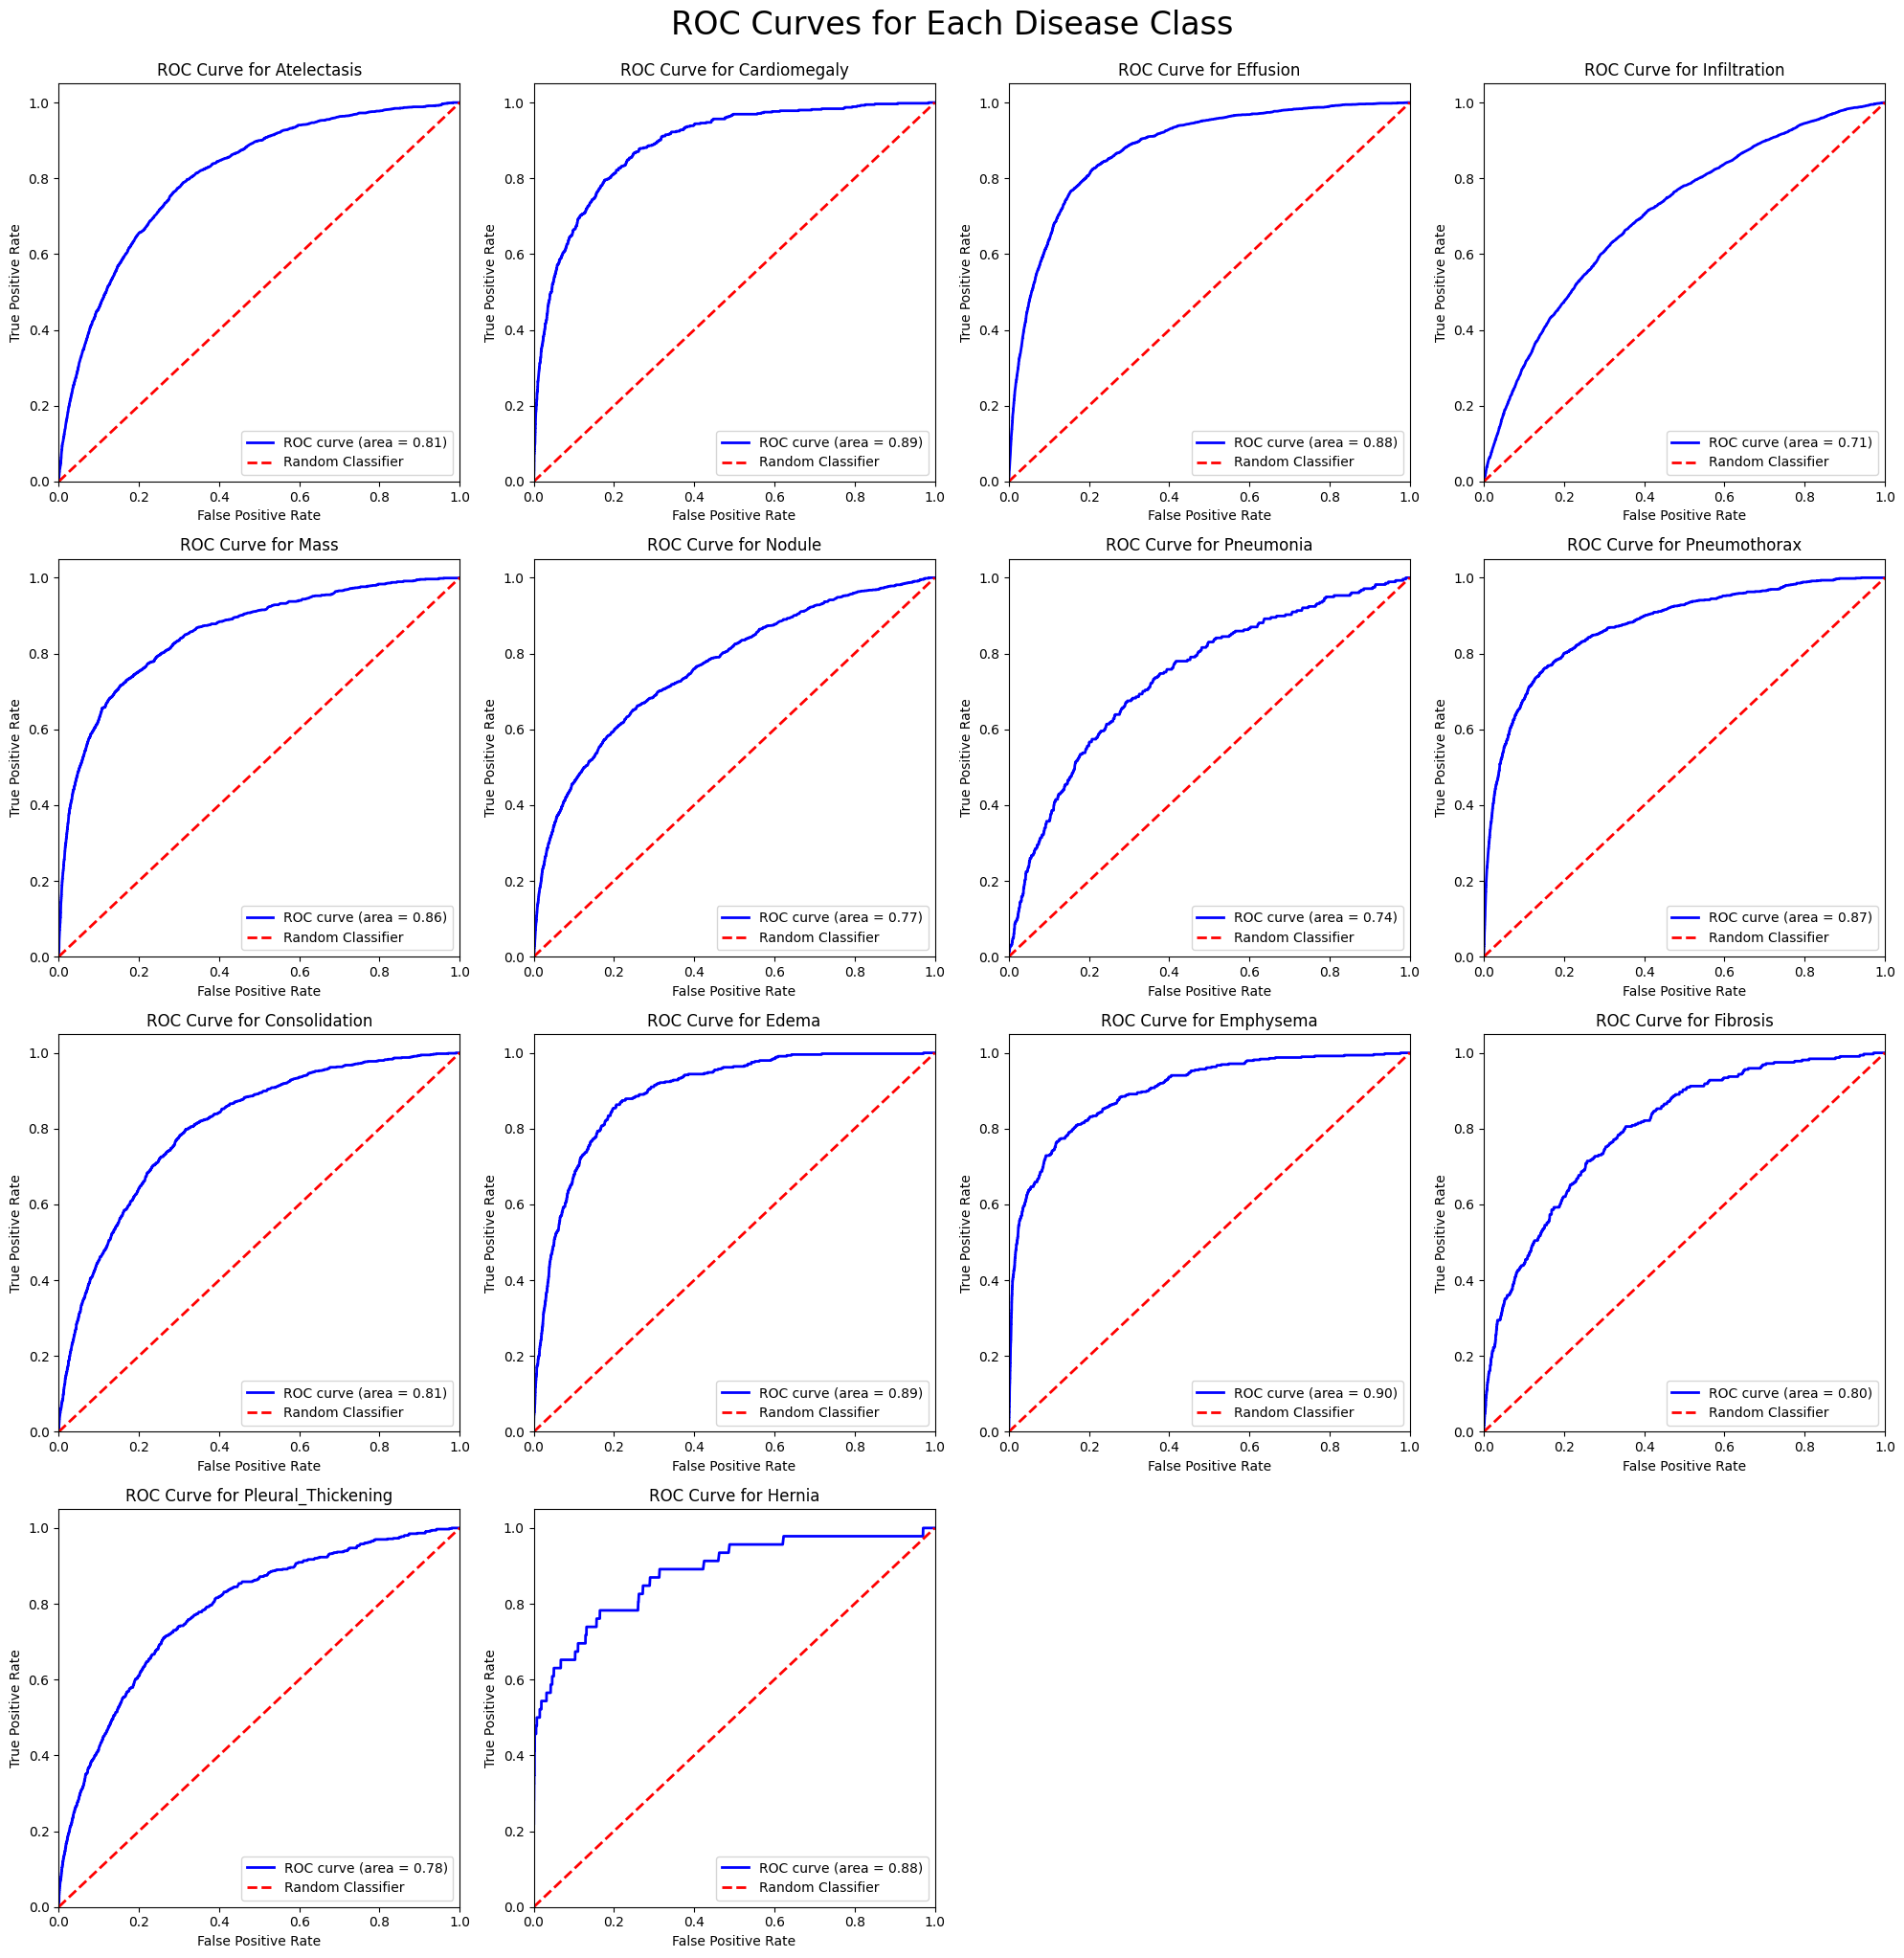

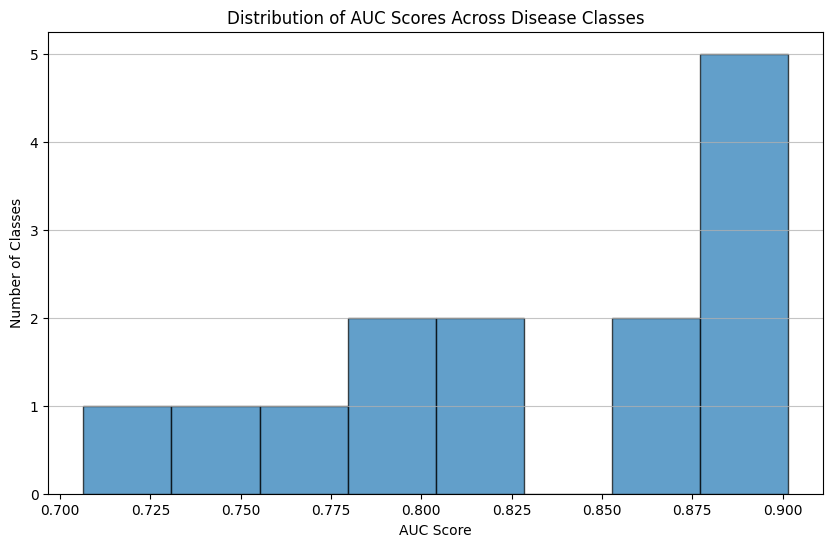


--- Insights from ROC Curves and AUC Distribution ---
The average AUC across all 14 disease classes is: 0.8275

Individual AUC scores are:
  Atelectasis: 0.8075
  Cardiomegaly: 0.8890
  Effusion: 0.8790
  Infiltration: 0.7064
  Mass: 0.8550
  Nodule: 0.7657
  Pneumonia: 0.7412
  Pneumothorax: 0.8746
  Consolidation: 0.8055
  Edema: 0.8943
  Emphysema: 0.9015
  Fibrosis: 0.8007
  Pleural_Thickening: 0.7839
  Hernia: 0.8813


In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Create a figure for ROC curves with multiple subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

for i, class_name in enumerate(CLASSES):
    ax = axes[i]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])

    # Plot ROC curve
    ax.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {individual_aucs[i]:.2f})')
    ax.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Classifier')

    # Set plot details
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {class_name}')
    ax.legend(loc="lower right")

# Hide any unused subplots if CLASSES count is less than 16
for j in range(len(CLASSES), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('ROC Curves for Each Disease Class', y=1.02, fontsize=24)
plt.show()

# Create a histogram of AUC scores
plt.figure(figsize=(10, 6))
plt.hist(individual_aucs, bins=8, edgecolor='black', alpha=0.7)
plt.title('Distribution of AUC Scores Across Disease Classes')
plt.xlabel('AUC Score')
plt.ylabel('Number of Classes')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Summarize insights
print("\n--- Insights from ROC Curves and AUC Distribution ---")
print(f"The average AUC across all 14 disease classes is: {avg_auc:.4f}")
print("\nIndividual AUC scores are:")
for i, class_name in enumerate(CLASSES):
    auc_score = individual_aucs[i]
    print(f"  {class_name}: {auc_score:.4f}")
